In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from numpy.random import Generator, PCG64

# Example of Bounded Noise: Telegraphic Noise 

In this lecture we will work a bit with the a bounded noise known as **telegraphic noise** and we will make some comparison with the classical gaussian white noise $\xi_W(t)$ and with an approximation of the telegraphic known as **Sine-Wiener**. First let's express the function using a generic noise $\xi(t)$ not specifically defined:

$$
\frac{dx}{dt} = -\gamma x + \omega\xi(t)
$$

with $\gamma,\omega\in\mathbb{R}^+$. So if we consider no noise we will have simply an exponential distribution converging to 0 asympthotically. Let's try to model it with different noises trying to see if there are some differences in the behaviour. 

## Telegraphic Noise

Now let's start with the so called telegraphic noise. This noise is a particular case of the variant of the **Dichotomous Markov Noise** known as **functional usage** of the DMN. While in the mechanistic usage we have two completely different differential equations and a switch between the twos in the functional usage we have a part of the equation which is fixed and a term as two possible values. For our problem let's pick that:

$$
\xi(t)=
\begin{cases}
    A: 1\\
    B: -1
\end{cases}
$$

So we have the two possible cases $A$ and $B$. Now a telegraphic noise, or more in general a DMN, is characterize by a stochastic transition between a state and another. We can define so a certain $P_A$ of transitioning $A\rightarrow B$ and complementary the transition $B\rightarrow A$ will have probability $1-P_A$.

So to implement our problem we will need to check at each step if the transition occurs. So let's try to simulate firstly only the noise ($\gamma=0$ and $\omega=1$) to see if we are able to obtain the hoped results. We will modify the usual class

In [2]:
#We need to change the function, the class vars and the stochastic formula

class Only_Noise(object):
    '''
    This function will simulate trajectories for pure telegraphic noise
    '''

    #WE CHANGE THE CONSTRUCTOR TO PASS THE PROBABILITY AND THE INITIAL STATE
    def __init__(self,PT:float)->None:
        self.__prob_transition = PT
        self.__actual_state = 1.0 #WE FIX IT EQUAL TO 1.0 BUT WE WILL CHANGE IT LATER.
        self.__rng = Generator(PCG64()) #NOW WE WILL DEFINE THE GENERATOR UPON CONSTRUCTION

        if(PT<0 or PT>1): #CHECK THAT IS A PROBABILITY
            raise RuntimeError("PT has to be a probability!")

        return


    def __checkInputs(self,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        #WE HAVE REMOVED THE POSITIVITY REQUEST IN THIS CASE!

        #T checks:
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        #N checks:
        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return

    #NEW FUNCTION!!!!!!!!! TO COMPUTE THE NEW STATE FOR THE TRAJ
    def __compute_new_state(self)->None:
        '''
        This function will check if the transition
        occurs and update the state
        '''
        r = self.__rng.uniform() #Generate the random number in (0,1)
        
        if(self.__actual_state==1):
            if(r<=self.__prob_transition):
                self.__actual_state = -1
        else:
            if(r<=(1-self.__prob_transition)):
                self.__actual_state = 1
                
        return

    #NEW FUNCTION!!!!!!!!! TO PRODUCE THE INITIAL STATE
    def __sort_initial_state(self)->int:
        '''
        Sort the initial state for the system
        '''
        r = self.__rng.uniform()

        if(r<=self.__prob_transition):
            return 1
        else:
            return -1

    def __RK4(self,t_n: float,y_n: float,h: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4
        '''
        #Perform the check of the inputs. For N we hard code a good 
        self.__checkInputs(t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: 0
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
    
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory.
        '''
        #Check the inputs
        self.__checkInputs(T,N)
        self.__actual_state = self.__sort_initial_state() #SET THE INITIAL STATE

        if T==0:
            return np.array([x0])

        #Setup step lenght and traj array
        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        #NOW WE HAVE NO MORE THE RNG GENERATORE HERE BUT UPON CONSTRUCTION!

        for i in range(1,N+1):
            time[i] = i*h
            self.__compute_new_state()
            dx = self.__RK4(time[i-1],traj[i-1],h) #determinstic part
            dx += self.__actual_state
            traj[i] = dx #WE HAVE REMOVED THE DEPENDENCE OF THE PREVIOUS POINT BECAUSE WE WANT ONLY THE NOISE.
        return traj,time

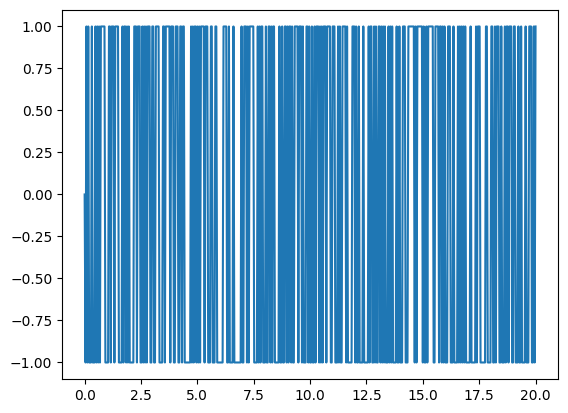

In [3]:
system = Only_Noise(0.5)

tr1, time1 = system.simulateTraj(0.0,20,500)
plt.plot(time1,tr1)

In [4]:
omega = [-1.0,1.0]
Nbins = 200 #100
Nsim = 1000 #10000
m = (omega[1]-omega[0])/Nbins
system = Only_Noise(0.5)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),20,500)
    for i in range(Nbins):
        if ptraj[-1] <= (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break

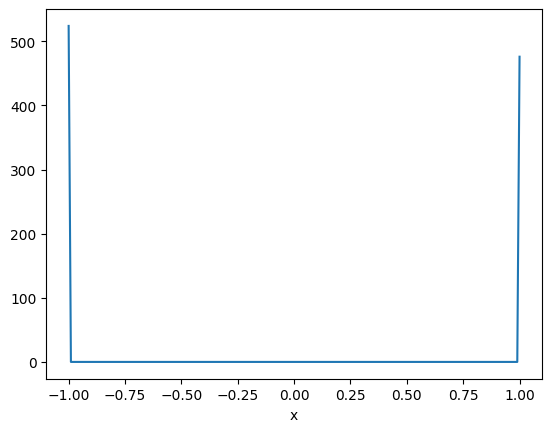

In [5]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(omega[0]-0.1,omega[1]+0.1)
plt.plot(x,bins)

Now we can try to implement the final system and to simulate a trajectory

In [6]:
#We need to change the function, the class vars and the stochastic formula

class Telegraphic(object):
    '''
    This function will simulate trajectories for the system
    '''

    #NOW WE HAVE ALSO TO PASS THE PARAMETERS GAMMA AND OMEGA
    def __init__(self,PT:float,omega: float,gamma:float)->None:
        self.__prob_transition = PT

        self.__rng = Generator(PCG64())
        self.__omega=omega
        self.__gamma=gamma
        self.__actual_state = 1 

        if(PT<0 or PT>1): 
            raise RuntimeError("PT has to be a probability!")

        if(gamma<0 or omega<0):
            raise RuntimeError("Both gamma and omega has to be non negative")
            
        return


    def __checkInputs(self,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''

        #T checks:
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        #N checks:
        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return
        
    def __sort_initial_state(self)->int:
        '''
        Sort the initial state for the system
        '''
        r = self.__rng.uniform()

        if(r<=self.__prob_transition):
            return 1
        else:
            return -1

    def __compute_new_state(self,step:float)->None:
        '''
        This function will check if the transition
        occurs and update the state
        '''
        r = self.__rng.uniform() 
        
        if(self.__actual_state==1):
            if(r<=(self.__prob_transition*step)):
                self.__actual_state = -1
        else:
            if(r<=((1-self.__prob_transition)*step)):
                self.__actual_state = 1
                
        return

    def __RK4(self,t_n: float,y_n: float,h: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4
        '''
        self.__checkInputs(t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: -self.__gamma*x #Now we put here the deterministic function
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
        
    
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory
        '''
        #Check the inputs
        self.__checkInputs(T,N)
        self.__actual_state = self.__sort_initial_state() 

        if T==0:
            return np.array([x0])

        #Setup step lenght and traj array
        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        for i in range(1,N+1):
            time[i] = i*h
            self.__compute_new_state(h)
            dx = self.__RK4(time[i-1],traj[i-1],h) 
            dx += self.__omega*self.__actual_state*h 
            traj[i] = traj[i-1] + dx  

        return traj,time

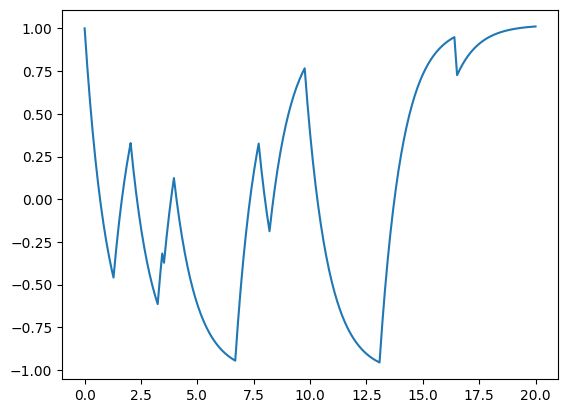

In [7]:
system = Telegraphic(0.5,1.0,1.0)

tr1, time1 = system.simulateTraj(1,20,500)
plt.plot(time1,tr1)

Doing a bit of qualitative analysis is possible to verify that for the positive state we have that the attractor point is given by $\omega/\gamma$ so increasing the fluctuations we will have a greater attractor and for a stronger decaying process we will have a lower attractor. A similar discussion can be made for the negative state.

We can check these results using our usual simulations.

In [8]:
omega = [-1.0,1.0]
Nbins = 150 #100
Nsim = 1000 #10000
m = (omega[1]-omega[0])/Nbins
system = Telegraphic(0.5,1.0,1.0)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),20,500)
    for i in range(Nbins):
        if ptraj[-1] <= (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


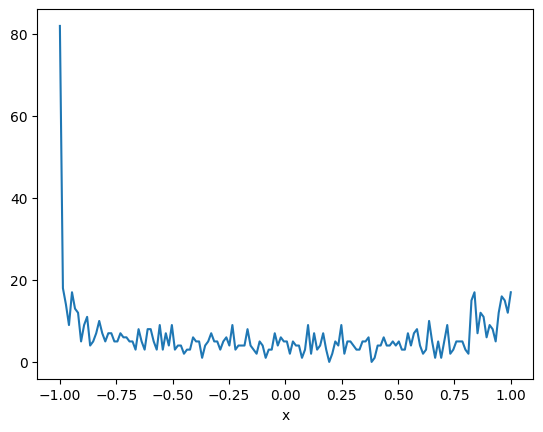

In [9]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(omega[0]-0.1,omega[1]+0.1)
plt.plot(x,bins)

As we can observe we are finding the two speculated attractive points but that's strange because we have seen for the noise that the two state would have equal probability. For now let's continue but why this happens?

Let's see now what happens if we push the problem in a more extreme situation using the parameters:

In [10]:
omega = [-0.3,0.3]
Nbins = 150 #100
Nsim = 1000 #10000
m = (omega[1]-omega[0])/Nbins
system = Telegraphic(0.1,1.0,4.0)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),20,500)
    for i in range(Nbins):
        if ptraj[-1] <= (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


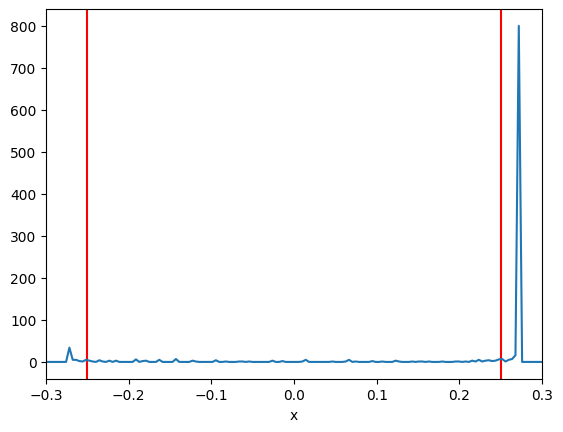

In [11]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.axvline(x = 0.25, color = 'r')
plt.axvline(x = -0.25, color = 'r')
plt.xlim(omega[0],omega[1])
plt.plot(x,bins)

There are theoretically no other NIT for our problem. If we look more we will also been able to see that the distribution is almost immune to the ratio between $\omega$ and $\gamma$ other than the position of the attractor point. However looking more deeply to our results if we try to move away from this ideal situation we can observe that the attractors are not precisely placed on the $\omega/\gamma$ value but instead they seem to be slighlty demished. Looking back to the equation this shift of the attractors is unconcivable also because the shift is upward. 

Playing a bit with all the parameters including the time lenght and the number of simulation we can find that for longer simulation, with fixed steps, this shift increase and for fewer number of steps this problem also became larger. So we can start to make a guess: this is an error problem! 

In [12]:
#We need to change the function, the class vars and the stochastic formula

class Telegraphic(object):
    '''
    This function will simulate trajectories for the system using the telegraphic noise
    '''
    def __init__(self,PT:float,omega: float,gamma:float)->None:
        self.__prob_transition = PT

        self.__rng = Generator(PCG64())
        self.__omega=omega
        self.__gamma=gamma
        self.__actual_state = 1 

        if(PT<0 or PT>1): 
            raise RuntimeError("PT has to be a probability!")

        if(gamma<0 or omega<0):
            raise RuntimeError("Both gamma and omega has to be non negative")
            
        return


    def __checkInputs(self,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''

        #T checks:
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        #N checks:
        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return
        
    #New function to sort the initial state
    def __sort_initial_state(self)->int:
        '''
        Sort the initial state for the system
        '''
        r = self.__rng.uniform()

        if(r<=self.__prob_transition):
            return 1
        else:
            return -1

    def __compute_new_state(self,step:float)->None:
        '''
        This function will check if the transition
        occurs and update the state
        '''
        r = self.__rng.uniform()
        
        if(self.__actual_state==1):
            if(r<=(self.__prob_transition*step)):
                self.__actual_state = -1
        else:
            if(r<=((1-self.__prob_transition)*step)):
                self.__actual_state = 1
                
        return

    def __RK4(self,t_n: float,y_n: float,h: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4
        '''
        self.__checkInputs(t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        #NOW WE IMPLEMENT THE STOCHASTIC CONTRIBUTION HERE!
        f = lambda x: -self.__gamma*x + self.__omega*self.__actual_state
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
        
    
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory
        '''
        #Check the inputs
        self.__checkInputs(T,N)
        self.__actual_state = self.__sort_initial_state()

        if T==0:
            return np.array([x0])

        #Setup step lenght and traj array
        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        for i in range(1,N+1):
            time[i] = i*h
            self.__compute_new_state(h)
            dx = self.__RK4(time[i-1],traj[i-1],h) #determinstic part
            #The noise addition is now inside the RK4!
            traj[i] = traj[i-1] + dx

        return traj,time

In [13]:
omega = [-0.3,0.3]
Nbins = 100 #100
Nsim = 1000 #10000
m = (omega[1]-omega[0])/Nbins
system = Telegraphic(0.2,1.0,4.0)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,500)
    for i in range(Nbins):
        if ptraj[-1] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


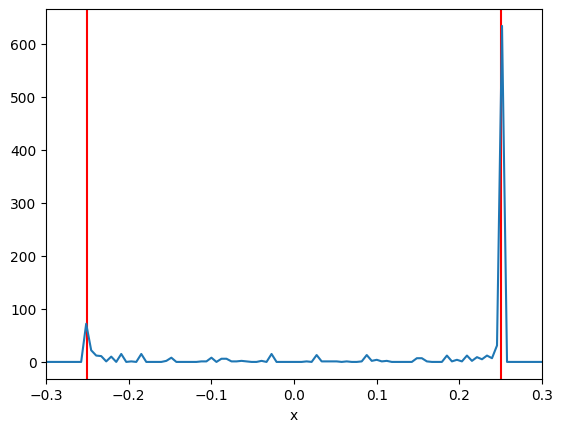

In [14]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(omega[0],omega[1])
plt.axvline(x = 0.25, color = 'r')
plt.axvline(x = -0.25, color = 'r')
plt.plot(x,bins)

Much better! So for the first time we have seen what kind of problems can occur with the simulations and the first relevant apparition of the error. We will talk about that in the future...

## Sine-Wiener

A useful approximation of the telegraphic noise is given by the so called **Sine-Wiener** noise. So keeping the same general equation than before, this time we will use as noise this one:

$$
\xi(t)=B\sin(cW(t))
$$

where $B$ is the amplitude and $c$ commands the sharpness and the fluctuations of the sin. $W(t)$ is the usual Wiener process. 

So for our case we will opt to take $B=1$ (to have the same amplitude of the telegraphic) and the frequence will be $c=1$.

We need also to understand how the $W(t)$ and this will be our first problem. In fact the Wiener process is a function defined as

$$
W'(t)=\xi_G(t) \quad\Rightarrow\quad dW = 1\cdot dW
$$

And is not possible to express directly the Wiener process so we need to do a simulation inside the simulation! [BLACKBOARD]

Now let's start producing again the class for the noise

In [15]:
class Sine_Wiener_Noise(object):
    '''
    This function will simulate trajectories for the Sine-Wiener noise
    '''
    #We need only the c value to set the frequency
    def __init__(self,c: float)->None:
        self.__rng = Generator(PCG64())
        self.__c = c
            
        return

    def __checkInputs(self,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return
        
    def __RK4(self,t_n: float,y_n: float,h: float,W: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4
        '''
        self.__checkInputs(t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: 0
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory
        '''
        self.__checkInputs(T,N)

        if T==0:
            return np.array([x0])

        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0


        wie = np.zeros(N+1,dtype=float)
        wie[0] = 0.0 
        
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        for i in range(1,N+1):
            time[i] = i*h
            wie[i] = wie[i-1] + self.__rng.normal()*np.sqrt(h)
            dx = self.__RK4(time[i-1],traj[i-1],h,wie[i-1]) #Now we pass
            dx = dx + np.sin(self.__c*wie[i-1])
            traj[i] = dx

        return traj,time

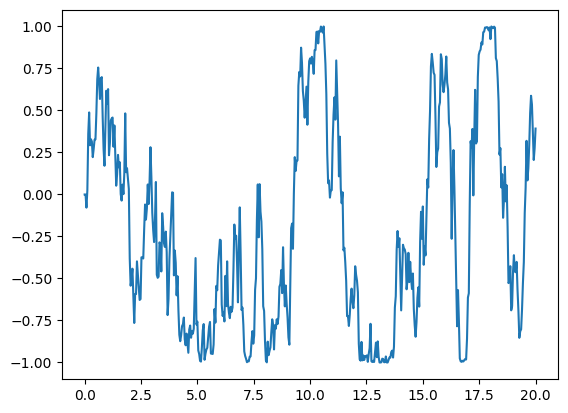

In [16]:
system = Sine_Wiener_Noise(1.0)

tr1, time1 = system.simulateTraj(0.0,20,500)
plt.plot(time1,tr1)

In [17]:
omega = [-1.0,1.0]
Nbins = 150 #100
Nsim = 1000 #10000
m = (omega[1]-omega[0])/Nbins
system = Sine_Wiener_Noise(1.0)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,1000)
    for i in range(Nbins):
        if ptraj[-1] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


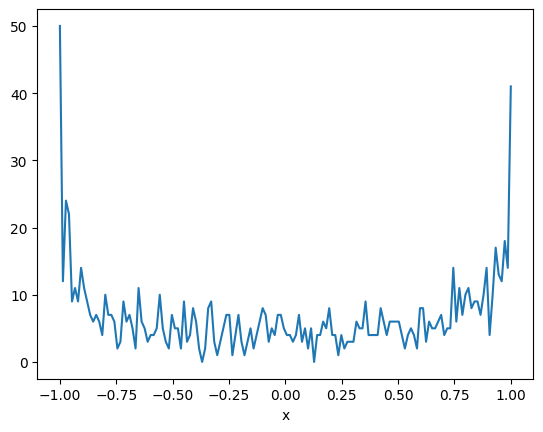

In [18]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(omega[0]-0.1,omega[1]+0.1)
plt.plot(x,bins)

We can notice that the noise is quite good and the distribution is quite similar with the noise of the telegraphic noise however we have not the two Dirac delta in $\pm1$ and the intermediate points have non 0 probability. Anyway is very peaked in the same positions.

In [19]:
class Sine_Wiener(object):
    '''
    This function will simulate trajectories for the system with Sine-Wiener noise
    '''
    #In the constructor we don't have to add anything. We can instead remove the initial state and the probability transition.
    def __init__(self,omega: float,gamma:float)->None:
        self.__rng = Generator(PCG64())
        self.__omega=omega
        self.__gamma=gamma
        
        if(gamma<0 or omega<0):
            raise RuntimeError("Both gamma and omega has to be non negative")
            
        return

    #This function remains the same
    def __checkInputs(self,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return
        
    #__sort_initial_state is not necessary anymore!

    #Also __compute_new_state is not useful now!
    
    #Let's compute the update of our global process all in the RK4 to reduce errors.
    #To do so let's add an argument to pass the Wiener
    def __RK4(self,t_n: float,y_n: float,h: float,W: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4
        '''
        self.__checkInputs(t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: -self.__gamma*x + self.__omega*np.sin(W)
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
        
    #Having seen 
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory
        '''
        self.__checkInputs(T,N)
        #Not having an initial state we do not need to update it

        if T==0:
            return np.array([x0])

        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0

        #We create also a trajectory for the Wiener
        wie = np.zeros(N+1,dtype=float)
        wie[0] = 0.0 #we setup it in its mean
        
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        for i in range(1,N+1):
            time[i] = i*h
            #We have no more the update of the state!
            
            #We can simulate the Wiener using the classical Maruyama
            wie[i] = wie[i-1] + self.__rng.normal()*np.sqrt(h)

            dx = self.__RK4(time[i-1],traj[i-1],h,wie[i-1])#Now we pass
            traj[i] = traj[i-1] + dx

        return traj,time

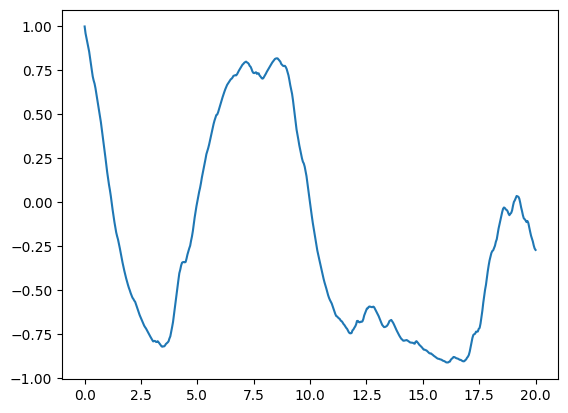

In [20]:
system = Sine_Wiener(1.0,1.0)

tr1, time1 = system.simulateTraj(1.0,20,500)
plt.plot(time1,tr1)

Doing a bit of qualitative analysis we have that the expected behaviour in the critical points so the sin-Wiener is comparable with a telegraphic noise when the transition probability is 0.5. The maximum value is still $\omega/\gamma$ and as we can observe this simulation tends to stay is less extreme in its behaviour at least for $c=1$. However the variety of the behaviour is wider and the trajectories are pretty different.
So we can affirm strongly that the single simulation is something different than the telegraphic noise but, as always, our interest is the SS distribution so let's compute the distribution 

In [21]:
omega = [-1.0,1.0]
Nbins = 150 #100
Nsim = 1000 #10000
m = (omega[1]-omega[0])/Nbins
system = Sine_Wiener(1.0,1.0)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),20,500)
    for i in range(Nbins):
        if ptraj[-1] <= (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


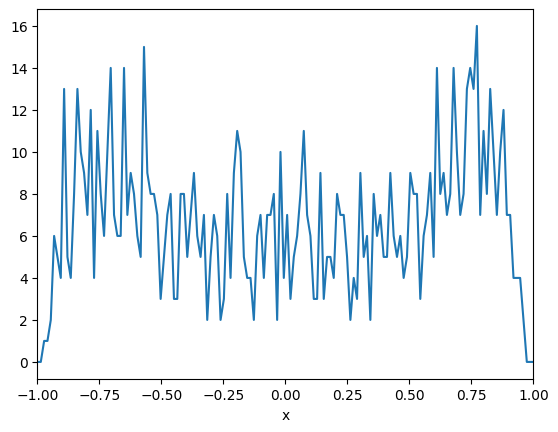

In [22]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(omega[0],omega[1])
plt.plot(x,bins)

As we can see the fact that our solutions tends to spend most of the time in the central area produce for 1000 simulations almost a constant distribution. Let's try with more simulations and longer ones.

In [23]:
omega = [-1.0,1.0]
Nbins = 150 #100
Nsim = 10000 #10000
m = (omega[1]-omega[0])/Nbins
system = Sine_Wiener(1.0,1.0)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,1000)
    for i in range(Nbins):
        if ptraj[-1] <= (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


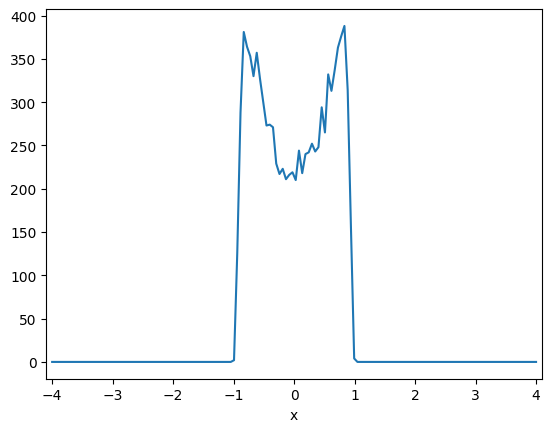

In [24]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(omega[0]-0.1,omega[1]+0.1)
plt.plot(x,bins)

With 10000 simulations we start to see something however there are some differences. Firstly the two attractor points are actual repulsor and the attractors are two in-between points but the qualitative analysis does not report the presence of this two points. This effect is due to the simulations in fact for larger value of $t$ we have that the peaks move towards $\pm1$. This effect is due to the fact that is not so easy for the Wiener process to arrive to a value equal to 1.0 even if such is possible also for only 1 seconds of simulations so we have that $sin$ will not arrive to its maximum/minimum value so easily and frequently. On the other end, differently from the telegraphic noise, we have that having a weaker noise and an attractor effect on given by $\lambda$ this time we have that our elements tends to fall towards 0.  

If we augment the frequence $c$ this problem actually became worse and worse because the variations of the Wiener process became too much indipendent and as we have seen in the first noise having too small fluctuations and noise became very weak. In a first phase this noise transform our distribution of the Sine-Wiener making it more and more similar to a white gaussian. Lowering the $c$ actually improve our solution:  

In [25]:
#WE SIMPLY ADD c TO THE CONSTRUCTOR AND WE LINK IT TO THE RUNGE KUTTA

class Sine_Wiener(object):
    '''
    This function will simulate trajectories for the system with Sine-Wiener noise.
    '''
    #In the constructor we don't have to add anything. We can instead remove the initial state and the probability transition.
    def __init__(self,omega: float,gamma:float,c: float)->None:
        self.__rng = Generator(PCG64())
        self.__omega=omega
        self.__gamma=gamma
        self.__c = c
        
        if(gamma<0 or omega<0):
            raise RuntimeError("Both gamma and omega has to be non negative")
            
        return

    #This function remains the same
    def __checkInputs(self,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return
        
    #__sort_initial_state is not necessary anymore!

    #Also __compute_new_state is not useful now!
    
    #Let's compute the update of our global process all in the RK4 to reduce errors.
    #To do so let's add an argument to pass the Wiener
    def __RK4(self,t_n: float,y_n: float,h: float,W: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4
        '''
        self.__checkInputs(t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: -self.__gamma*x + self.__omega*np.sin(self.__c*W)
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
        
    #Having seen 
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory
        '''
        self.__checkInputs(T,N)
        #Not having an initial state we do not need to update it

        if T==0:
            return np.array([x0])

        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0

        #We create also a trajectory for the Wiener
        wie = np.zeros(N+1,dtype=float)
        wie[0] = 0.0 #we setup it in its mean
        
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        for i in range(1,N+1):
            time[i] = i*h
            #We have no more the update of the state!
            
            #We can simulate the Wiener using the classical Maruyama
            wie[i] = wie[i-1] + self.__rng.normal()*np.sqrt(h)

            dx = self.__RK4(time[i-1],traj[i-1],h,wie[i]) #Now we pass
            traj[i] = traj[i-1] + dx

        return traj,time

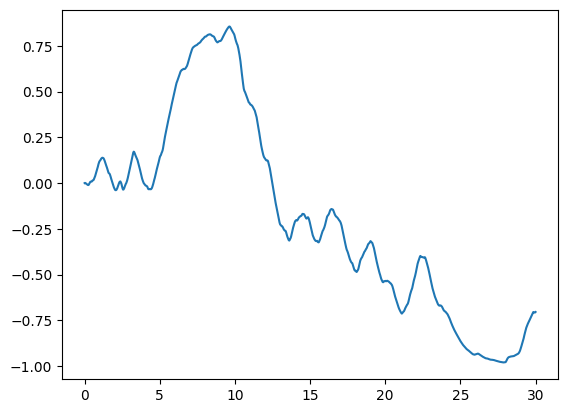

In [26]:
system = Sine_Wiener(1.0,1.0,0.5)

tr1, time1 = system.simulateTraj(0.0,30,10000)
plt.plot(time1,tr1)

In [27]:
omega = [-1.0,1.0]
Nbins = 250 #100
Nsim = 10000 #10000
m = (omega[1]-omega[0])/Nbins
system = Sine_Wiener(1.0,1.0,0.15)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),40,1000)
    for i in range(Nbins):
        if ptraj[-1] <= (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


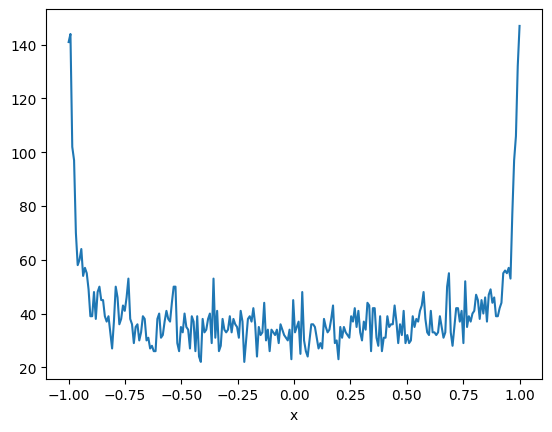

In [28]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(omega[0]-0.1,omega[1]+0.1)
plt.plot(x,bins)

However we have also some problems here! The first problem is if we lower the $c$ too much the fluctuations will become so weak, module speaking, that we will not be able to runaway from the center of the distribution in the length of the simulations. So we have to consider carefully the value of $c$. Doing some little experiments one could see that the value, adjusting properly the border of the domain, do not depends on the other parameters of the system neither the number of steps. However the lenght of the simulation is important. So lowering $c$ will require to have longer simulations to reach the steady state distribution. All of this is extensively explain in this [paper](https://arxiv.org/pdf/2107.09641) where the diffusive effect of $c^2$ (there $D$) is quantified and analyzed.

So looking at the results: we have that the Sine-Wiener is able to reproduce with a certain degree of approximation the value effects of the telegraphic noise even if we have non zero probability in the intermediate values and a bit of work with the parameters is needed. Moreover, the Sine-Wiener is unable to reproduce case where the probability for the two "states" is not equal.

## Gaussian white noise

Ok, now what will happen if we simply put $\xi(t)=\xi_G(t)$? This error is quite different from the other two even if we have said that for $c\gg 1$ the Sine-Wiener is a good approximation of the gaussian noise. In this case we can write the Ito formula

$$
dx = -\gamma x dt + \omega dW
$$

Let's do a bit of qualitative analysis to see if there are some kind of differences.

So we have a maximum for the probability distribution in 0. This results already tells us that our problem could show critical differences if we compare it with the telegraphic and Sine-Wiener noise

In [29]:
#WE CAN SIMPLY MODIFY THE HARVEST CLASS OF LESSON 6-7

class Gaussian(object):
    '''
    This function will simulate trajectories for the system with a gaussian noise
    '''

    #CONSTRUCTOR ## AVVISO NOTA MIA: DA CANCELLARE: SI FA IN CLASSE.
    def __init__(self,omega: float,gamma: float)->None:
        self.__omega=omega
        self.__gamma=gamma
        
        if(gamma<0 or omega<0):
            raise RuntimeError("Both gamma and omega has to be non negative")
        
        return

    def __checkInputs(self,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        #NO MORE CHECK ON THE X0 POSITIVITY

        #T checks:
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        #N checks:
        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return

    def __RK4(self,t_n: float,y_n: float,h: float)->float: 
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4
        '''
        self.__checkInputs(t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: -self.__gamma*x
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
        
    
    def simulateTraj(self,x0: float,T: float,N: int): 
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory
        '''
        self.__checkInputs(T,N)

        if T==0:
            return np.array([x0])

        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        rng = Generator(PCG64())

        for i in range(1,N+1):
            time[i] = i*h
            dx = self.__RK4(time[i-1],traj[i-1],h) 
            dx += self.__omega*traj[i-1]*(1.0-traj[i-1])*rng.normal()*np.sqrt(h)
            traj[i] = traj[i-1] + dx
            if traj[i]<0: traj[i]=0.0

        return traj,time

In [30]:
omega = [-0.1,0.1] #0,100
Nbins = 200 #100
Nsim = 10000 #10000
m = (omega[1]-omega[0])/Nbins
system = Gaussian(1.0,1.0)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    ptraj,ttraj = system.simulateTraj(rng_0.uniform(low=omega[0],high=omega[1]),50,1000)
    for i in range(Nbins):
        if ptraj[-1] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break

bins = bins/(Nsim*m)

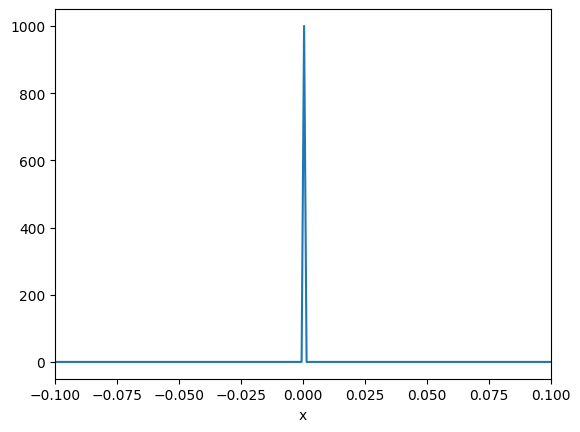

In [31]:
x = np.linspace(omega[0],omega[1],Nbins)

plt.xlabel("x")
plt.xlim(omega[0],omega[1])
plt.plot(x,bins)